## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1-Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Callibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


---
## 2-Apply a distortion correction to raw images.

Text(0.5, 1.0, 'Undistorted Image')

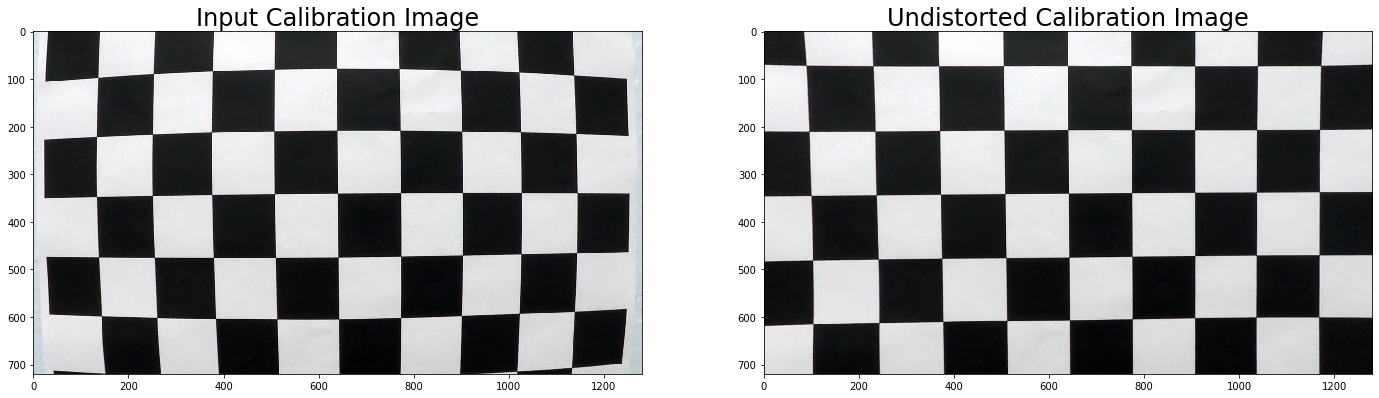

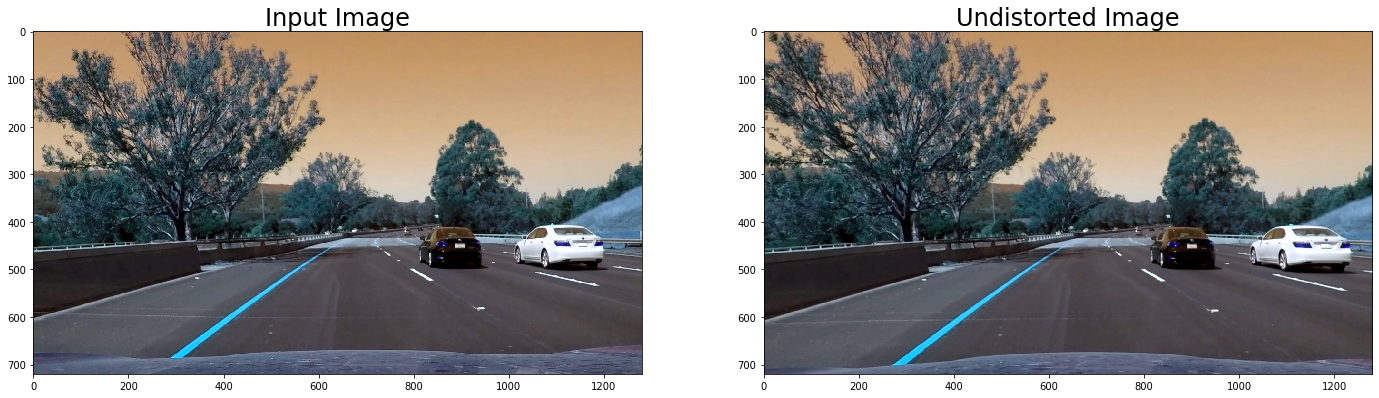

In [2]:
# Create a undistort image function
# Takes as input:
#  image: input image
#  objpoints: object points from camera calibration
#  imgpoints: image points from camera calibration
# Output: an undistorted image
def undistortImage(imgIn, objpoints, imgpoints):
    gray = cv2.cvtColor(imgIn,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return cv2.undistort(imgIn, mtx, dist, None, mtx)

# Show the undistorted test image
imgTest = cv2.imread('camera_cal/calibration1.jpg')
imgUndist = undistortImage(imgTest, objpoints, imgpoints)
# Display the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(imgTest)
ax1.set_title('Input Calibration Image', fontsize=24)
ax2.imshow(imgUndist)
ax2.set_title('Undistorted Calibration Image', fontsize=24)

# Test the undistort function
imgTest = cv2.imread('test_images/test6.jpg')
imgUndist = undistortImage(imgTest, objpoints, imgpoints)
# imgTest = cv2.GaussianBlur(imgUndist, (5, 5), 0)

# Display the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(imgTest)
ax1.set_title('Input Image', fontsize=24)
ax2.imshow(imgUndist)
ax2.set_title('Undistorted Image', fontsize=24)

In [3]:
# Undistort all images in test_images directory and save the result into output_images directory.
basepath = "./test_images/"
for file in os.listdir(basepath):
    if os.path.isfile(os.path.join(basepath, file)):
        imgIn = cv2.imread(os.path.join('test_images', file))
        imgOut = undistortImage(imgIn, objpoints, imgpoints)
        outputFileName = './output_images/' + file.split('.')[0] + '.jpg'
        cv2.imwrite(outputFileName, imgOut)

---
## 3-Use color transforms, gradients, etc., to create a thresholded binary image.


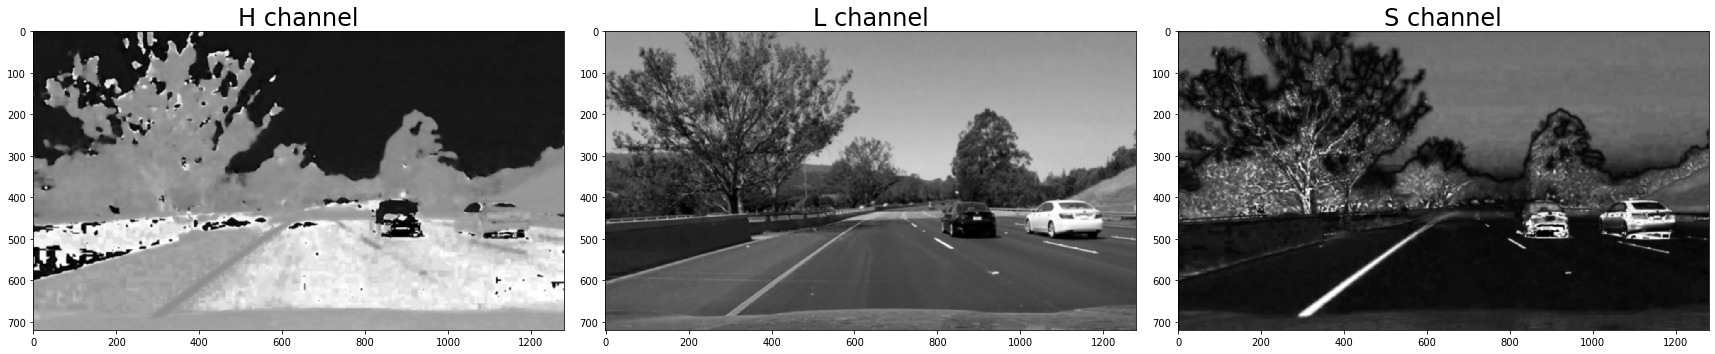

In [4]:
# 3.1: Color Transform
def RGB2HLS(imgIn):
    imgHLS = cv2.cvtColor(imgIn, cv2.COLOR_RGB2HLS)
    imgH = imgHLS[:,:,0]
    imgL = imgHLS[:,:,1]
    imgS = imgHLS[:,:,2]
    return imgH,imgL,imgS

# Extract test image channel
imgH, imgL, imgS = RGB2HLS(imgTest)

# Remove the noise 
kSize = 7
imgH = cv2.GaussianBlur(imgH, (kSize, kSize), 0)
imgL = cv2.GaussianBlur(imgL, (kSize, kSize), 0)
imgS = cv2.GaussianBlur(imgS, (kSize, kSize), 0)

# Display the results
f,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize = (24,9))
f.tight_layout(pad=3)
f.tight_layout()
ax1.set_title('H channel', fontsize=24)
ax1.imshow(imgH, cmap= 'gray')
ax2.set_title('L channel', fontsize=24)
ax2.imshow(imgL, cmap= 'gray')
ax3.set_title('S channel', fontsize=24)
ax3.imshow(imgS, cmap='gray')

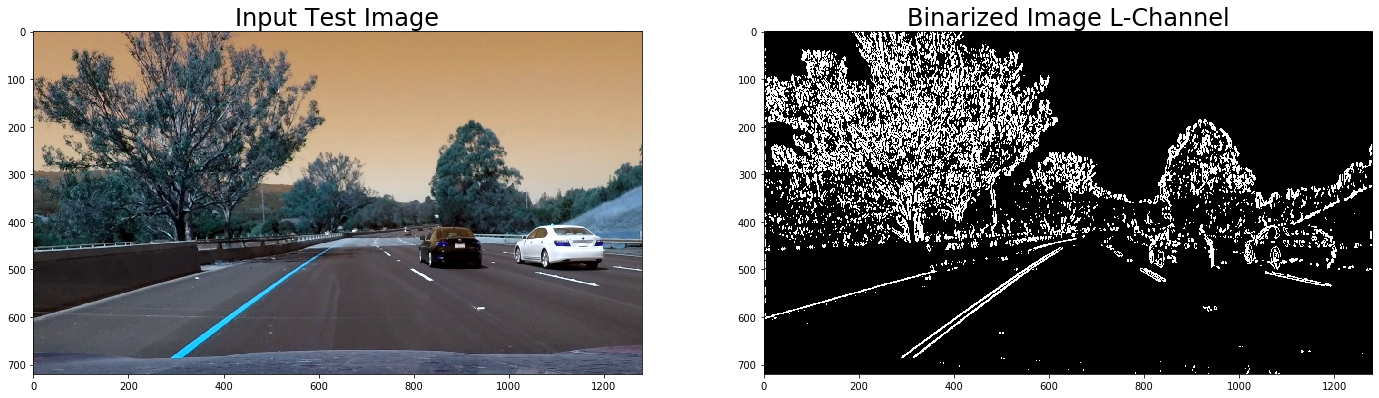

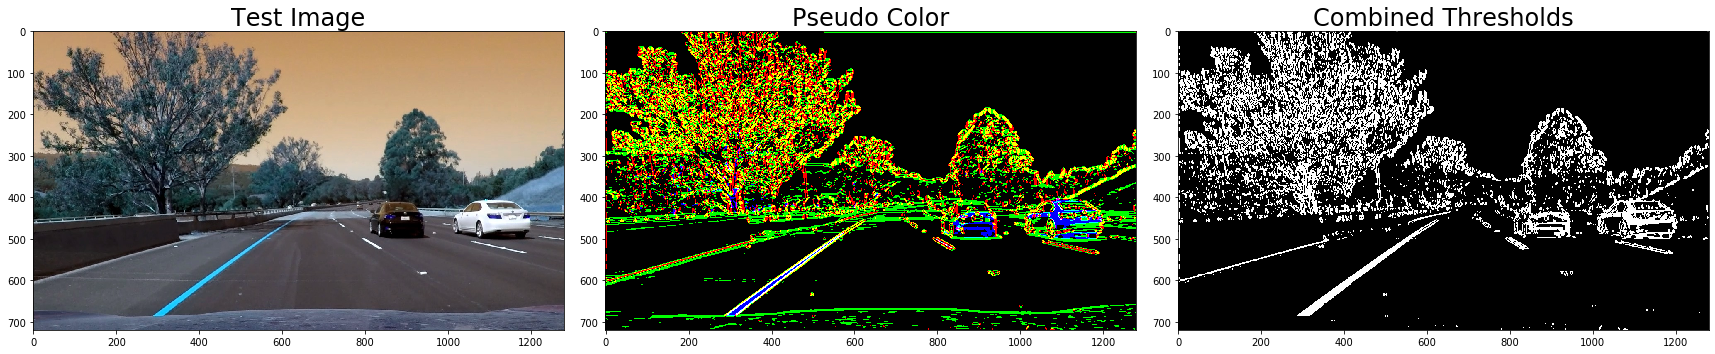

In [5]:
# 3.2: Create a binary image by applying Sobel gradient operator followed by thresholding
def binarizeImage(imgIn, orient = 'x', thresh=[0,255], kSize=5):
    if orient == 'x':
        imgSobelX = cv2.Sobel(imgIn, cv2.CV_64F, 1, 0, ksize=kSize)
        imgAbs = np.absolute(imgSobelX)
    elif orient == 'y':
        imgSobelY = cv2.Sobel(imgIn, cv2.CV_64F, 0, 1, ksize=kSize)
        imgAbs = np.absolute(imgSobelY)
    elif orient == 'mag':
        imgSobelX = cv2.Sobel(imgIn, cv2.CV_64F, 1, 0, ksize=kSize)
        imgSobelY = cv2.Sobel(imgIn, cv2.CV_64F, 0, 1, ksize=kSize)
        imgSobelMag = np.sqrt(imgSobelX**2 + imgSobelY**2)
        imgAbs = np.absolute(imgSobelMag)
    elif orient == 'dir':
        imgSobelX = cv2.Sobel(imgIn, cv2.CV_64F, 1, 0, ksize=kSize)
        imgSobelY = cv2.Sobel(imgIn, cv2.CV_64F, 0, 1, ksize=kSize)
        imgSobelDir = np.arctan2(np.absolute(imgSobelX), np.absolute(imgSobelY))
        imgAbs = np.absolute(imgSobelDir)
    else: # such as 'col'
        imgAbs = np.absolute(imgIn)
        
    imgScaled = np.uint8(255. * imgAbs / np.max(imgAbs))
    imgBinary = np.zeros_like(imgScaled)
    imgBinary[(imgScaled >= thresh[0]) & (imgScaled <= thresh[1])] = 1 # Thresholding
    return imgBinary

# Test the binarizeImage function on imgL
imgBinary = binarizeImage(imgL, orient='x', thresh=[20,100], kSize=5)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(imgTest)
ax1.set_title('Input Test Image', fontsize=24)
ax2.imshow(imgBinary, cmap='gray')
ax2.set_title('Binarized Image L-Channel', fontsize=24)

# Combine multiple thresholds
def thresholdImage(imgH, imgL, imgS, b_thresh=[0,255], c_thresh=[0,255], kSize=5):
    # Apply Soble threshold
    imgBinaryX = binarizeImage(imgL, orient='x', thresh=b_thresh, kSize=kSize)
    imgBinaryY = binarizeImage(imgL, orient='y', thresh=b_thresh, kSize=kSize)
    #imgBinaryMag = binarizeImage(imgL, orient='mag', thresh=b_thresh, kSize=kSize)
    #imgBinaryDir = binarizeImage(imgL, orient='dir', thresh=b_thresh, kSize=kSize)
    imgBinaryCol = binarizeImage(imgS, orient='col', thresh=c_thresh, kSize=kSize) # Threshold color channel
    
    imgCombined = np.zeros_like(imgBinaryX)
    imgCombined[((imgBinaryX == 1)) | (imgBinaryCol == 1)] = 1    
    
    # Create a pseudo color imagehe lowest value to 0 and the highest to 255. 
    imgColorBinary = np.dstack(((imgBinaryX*255, imgBinaryY*255, imgBinaryCol*255)))

    return imgColorBinary, imgCombined

# Test the thresholdImage function on imgL
imgColorBinary, imgCombined = thresholdImage(imgH, imgL, imgS, b_thresh=[20,100], c_thresh=[170,255], kSize=7) #10, 160
f,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize = (24,9))
f.tight_layout()
ax1.set_title('Test Image', fontsize=24)
ax1.imshow(imgTest)
ax2.set_title('Pseudo Color', fontsize=24)
ax2.imshow(imgColorBinary)
ax3.set_title('Combined Thresholds', fontsize=24)
ax3.imshow(imgCombined, cmap='gray')

---
## 4-Apply a perspective transform to rectify binary image ("birds-eye view").


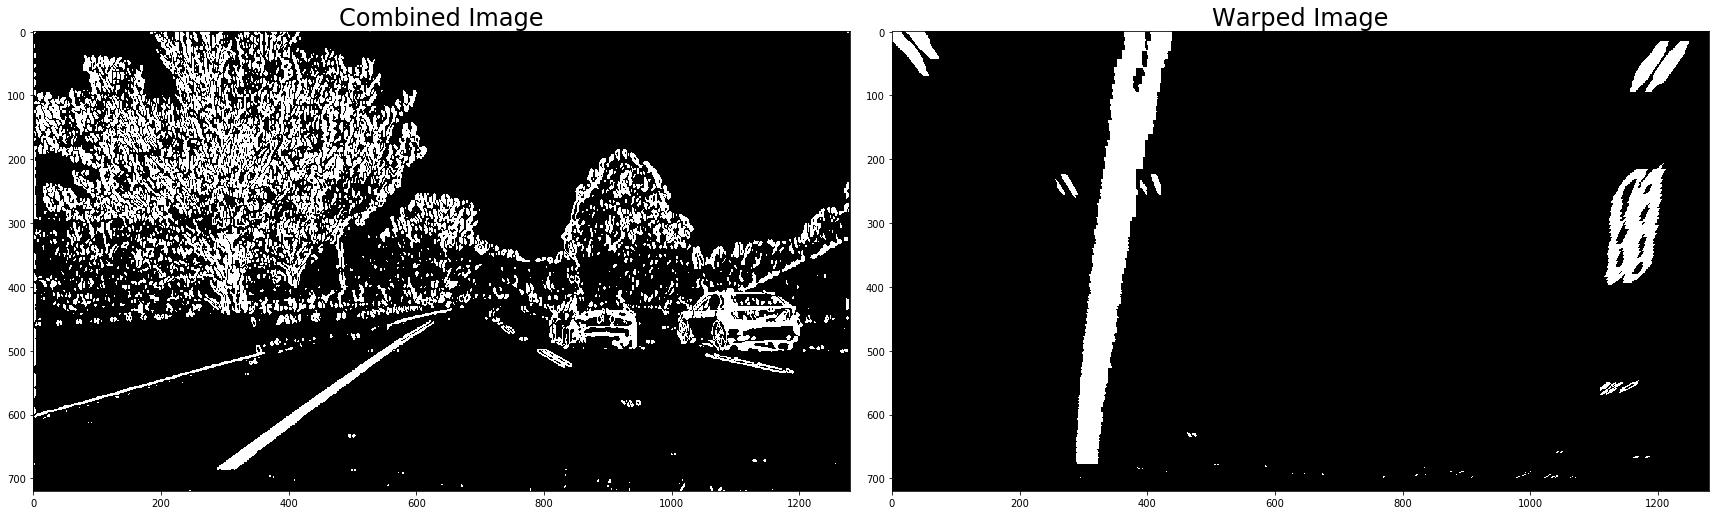

In [6]:
# Apply prespective transform on a ROI
def imageTransform(imgIn):
    srcROI = np.float32([[760,490],[1100,690],[280,690],[550,490]])
    dstROI = np.float32([[1100,155],[1100,680],[290,680],[300,155]])
    M = cv2.getPerspectiveTransform(srcROI, dstROI)
    Minv = cv2.getPerspectiveTransform(dstROI, srcROI)
    imgSize = (imgIn.shape[1], imgIn.shape[0])
    imgWarped = cv2.warpPerspective(imgIn, M, imgSize)
    return imgWarped, M, Minv

# Test the image transform function
imgWarped, M, Minv = imageTransform(imgCombined)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.set_title('Combined Image', fontsize=24)
ax1.imshow(imgCombined, cmap='gray')
ax2.set_title('Warped Image', fontsize=24)
ax2.imshow(imgWarped, cmap='gray')

---
## 5-Detect lane pixels and fit to find the lane boundary.


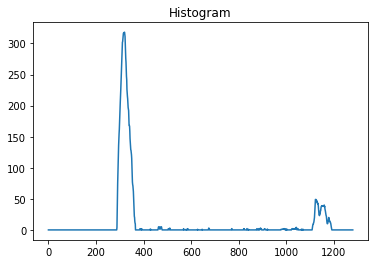

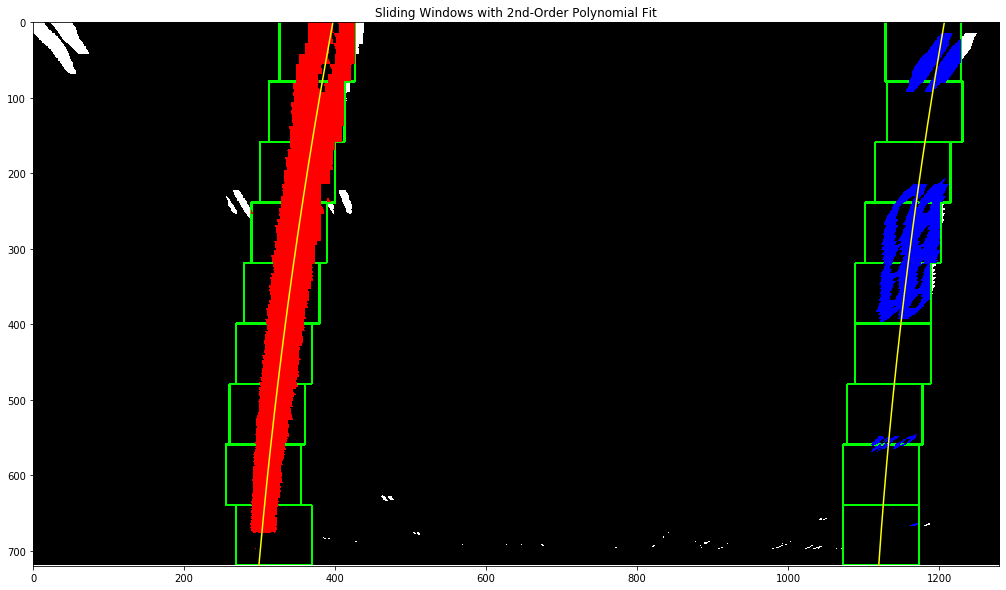

In [7]:
# Calculate histogram to determine road-lanes
def histogram(imgIn):
    return np.sum(imgIn[imgIn.shape[0]//2:,:], axis=0)

# Test histogram function 
plt.plot(histogram(imgWarped))
plt.title('Histogram')

# Identify lane pixels by Sliding Window, and apply a second-order polynomial fit
def slidingWindow(imgIn, plot=False):
    hist = histogram(imgIn)
    midpoint = np.int(hist.shape[0]/2) # image mid point
    leftXBase = np.argmax(hist[:midpoint]) # find peak in left half of the histogram
    rightXBase = np.argmax(hist[midpoint:]) + midpoint # peak in the right half as starting point

    nwindows = 9 # number of sliding windows
    winHeight = np.int(imgIn.shape[0]/nwindows) # set height of window
    nzIDX = imgIn.nonzero() # nonzero pixels in the image
    nzY = np.array(nzIDX[0]) # x-position of non-zero pixel
    nzX = np.array(nzIDX[1]) # y-position of non-zero pixel
    leftx_current = leftXBase # Current positions to be updated for left window
    rightx_current = rightXBase # Current positions to be updated for right window
    margin = 50 # Set the width of the windows +/- margin
    minpix = 50 # Set minimum number of pixels found to recenter window
    leftLaneIDX = [] # Create empty lists to receive left lane pixel indices
    rightLaneIDX = [] # Create empty lists to receive right lane pixel indices

    imgOut = np.dstack((imgIn, imgIn, imgIn))*255 # output image for visulization
    # Iterate through each windows
    for w in range(nwindows):
        winYLow = imgIn.shape[0] - (w+1) * winHeight # windows low along Y-direction
        winYHigh = imgIn.shape[0] - w * winHeight # windows high along Y-direction
        leftWinXLow = leftx_current - margin # left window low along x-direction
        leftWinXHigh = leftx_current + margin # left window high along x-direction
        rightWinXLow = rightx_current - margin # right window low along x-direction
        rightWinXHigh = rightx_current + margin # right window high along x-direction
        
        if(plot==True): # Draw the windows on the output image
            cv2.rectangle(imgOut,(leftWinXLow,winYLow),(leftWinXHigh,winYHigh),(0,255,0), 2) 
            cv2.rectangle(imgOut,(rightWinXLow,winYLow),(rightWinXHigh,winYHigh),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        goodLeftIDX = ((nzY >= winYLow) & (nzY < winYHigh) & (nzX >= leftWinXLow) &  (nzX < leftWinXHigh)).nonzero()[0]
        goodRightIDX = ((nzY >= winYLow) & (nzY < winYHigh) & (nzX >= rightWinXLow) &  (nzX < rightWinXHigh)).nonzero()[0]
        
        leftLaneIDX.append(goodLeftIDX) # Append the indices of left window to the list
        rightLaneIDX.append(goodRightIDX)  # Append the indices of left window to the list

        # If atleast minpix are found, recenter next window on their mean position
        if len(goodLeftIDX) > minpix: 
            leftx_current = np.int(np.mean(nzX[goodLeftIDX]))
        if len(goodRightIDX) > minpix:        
            rightx_current = np.int(np.mean(nzX[goodRightIDX]))

    # Concatenate the arrays of indices
    leftLaneIDX = np.concatenate(leftLaneIDX)
    rightLaneIDX = np.concatenate(rightLaneIDX)

    leftX = nzX[leftLaneIDX]   # Left lane x-position
    leftY = nzY[leftLaneIDX]   # Left lane y-position
    rightX = nzX[rightLaneIDX] # Right lane x-position
    rightY = nzY[rightLaneIDX] # Right lane y-position
    leftFit = np.polyfit(leftY, leftX, 2)    # Fit a second order polynomial to left lane points
    rightFit = np.polyfit(rightY, rightX, 2) # Fit a second order polynomial to right lane points

    return leftFit,rightFit,leftLaneIDX,rightLaneIDX,imgOut

# Plot Curve Lines
def drawCurveLines(imgIn, leftFit,rightFit, leftLaneIDX, rightLaneIDX,imgOut):
    nzIDX = imgIn.nonzero()
    nzY = np.array(nzIDX[0])
    nzX = np.array(nzIDX[1])
    imgOut[nzY[leftLaneIDX], nzX[leftLaneIDX]] = [255, 0, 0]
    imgOut[nzY[rightLaneIDX], nzX[rightLaneIDX]] = [0, 0, 255]
    plotY = np.linspace(0, imgIn.shape[0]-1, imgIn.shape[0] )
    leftFitX = leftFit[0] * plotY**2 + leftFit[1] * plotY +leftFit[2]
    rightFitX = rightFit[0] * plotY**2 + rightFit[1] * plotY + rightFit[2]
    
    plt.figure(figsize=(20,10))
    plt.imshow(imgOut)
    plt.title('Sliding Windows with 2nd-Order Polynomial Fit')
    plt.plot(leftFitX, plotY, color='yellow')
    plt.plot(rightFitX, plotY, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    #return out_img

leftFit, rightFit, leftLaneIDX, rightLaneIDX, imgOut = slidingWindow(imgWarped, plot=True)
drawCurveLines(imgWarped, leftFit, rightFit, leftLaneIDX, rightLaneIDX, imgOut)

---
## 6-Determine the curvature of the lane and vehicle position with respect to center.


In [8]:
def calculateROC(imgIn, leftFit, rightFit):
    YMPP = 30/720 # meters per pixel in y dimension
    XMPP = 3.7/700 # meters per pixel in x dimension
    
    plotY = np.linspace(0, imgIn.shape[0]-1, imgIn.shape[0] )
    leftX = leftFit[0]*plotY**2 + leftFit[1]*plotY +leftFit[2]
    rightX = rightFit[0]*plotY**2 + rightFit[1]*plotY + rightFit[2]
    carPos = imgIn.shape[1]/2
    # Fit new polynomials to x,y in world space
    leftFitCR = np.polyfit(plotY*YMPP, leftX*YMPP, 2)
    rightFitCR = np.polyfit(plotY*YMPP, rightX*YMPP, 2)
    # Calculate the new radii of curvature
    
    evalY = np.max(plotY)
    
    leftCurvature = ((1 + (2*leftFitCR[0]*evalY*YMPP + leftFitCR[1])**2)**1.5) / np.absolute(2*leftFitCR[0])
    rightCurvature = ((1 + (2*rightFitCR[0]*evalY*YMPP + rightFitCR[1])**2)**1.5) / np.absolute(2*rightFitCR[0])
    
    leftLaneBottom = (leftFit[0]*evalY)**2 + leftFit[0]*evalY + leftFit[2]
    rightLaneBottom = (rightFit[0]*evalY)**2 + rightFit[0]*evalY + rightFit[2]
    
    actualPos= (leftLaneBottom + rightLaneBottom)/2.0
    distance= (carPos - actualPos) * XMPP
    return (leftCurvature + rightCurvature)/2.0, distance
    
# Test the ROC and offset
curvature, distance = calculateROC(imgWarped, leftFit, rightFit)
print('Curvature:',curvature, 'm, Distance:', distance, 'm')

Curvature: 301.01724622575784 m, Distance: -0.8569001523377382 m


---
## 7-Warp the detected lane boundaries back onto the original image.


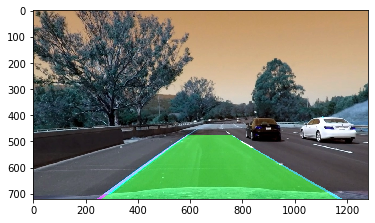

---
## 8-Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
